# An inferential problem: The Gender Wage Gap

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

Considering the above explanation, we will replicate the in-class exercise but focusing on the variables college-educated workers (scl, clg variables). As well as in the in-class exercise, the analysis will explain "partialling out", generating point estimates and standard errors.

## Data analysis

We consider the same subsample of the U.S. Current Population Survey (2015) as in the previous lab. Let us load the data set.

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
rdata_read = pyreadr.read_r("../../data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'data' ]

data.shape

(5150, 20)

To start our (causal) analysis, we compare the sample means given gender:

In [5]:
# variable names
varis = ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] 
names = ["Log Wage","Sex","Less then High School","High School Graduate","Some College","College Graduate","Advanced Degree",
                      "Northeast","Midwest","South","West","Experience"]
varis_names = dict(zip(varis,names))

In [6]:
# selecting a subset of interest (college and some college)
z_clg = data[(data['clg'] == 1) | (data['scl'] == 1) ]

# keeping variables of interest to do the table
z_clg_table = z_clg[ ["lwage","sex","scl","clg","ne","mw","so","we","exp1"] ]
print(z_clg.shape) # to estimate
print(z_clg_table.shape) #for the table
#z_clg

(3068, 20)
(3068, 9)


### 1.0 Main statistics 

In [7]:
z_clg_table['gender'] = np.where(z_clg_table['sex']==1 , "Woman", "Man")

C:\Users\Roberto\AppData\Local\Temp\ipykernel_18380\893247630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_clg_table['gender'] = np.where(z_clg_table['sex']==1 , "Woman", "Man")


Text(0.5, 0, '')

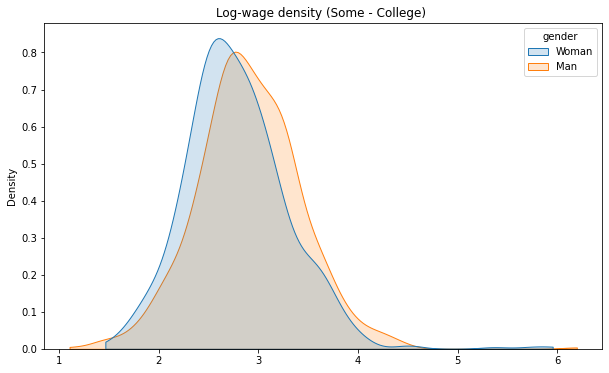

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

base1 = z_clg_table[z_clg_table['scl'] == 1]

sns.kdeplot(data=base1, x="lwage", hue="gender", cut=0, fill=True, common_norm=False, alpha=0.2)
plt.title("Log-wage density (Some - College) ")
plt.xlabel("")

Text(0.5, 0, '')

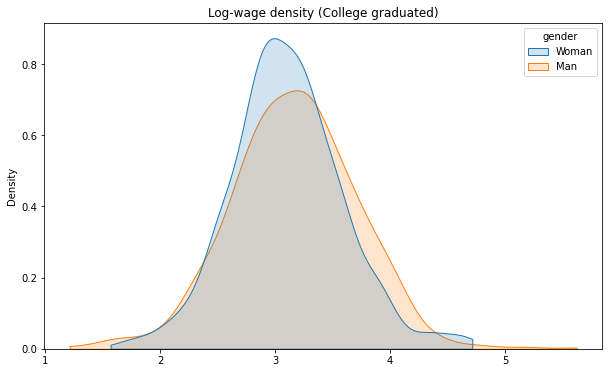

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

base1 = z_clg_table[z_clg_table['clg'] == 1]

sns.kdeplot(data=base1, x="lwage", hue="gender", cut=0, fill=True, common_norm=False, alpha=0.2)
plt.title("Log-wage density (College graduated)")
plt.xlabel("")

In [10]:
z_clg_table['total_scl'] = np.sum(z_clg_table['scl'])
z_clg_table['total_clg'] = np.sum(z_clg_table['clg'])

data = z_clg_table.groupby( [ 'gender' ] , as_index = False ).agg( 
                        total_gender = ( 'scl', np.sum ) , total = ('total_scl', np.mean))


C:\Users\Roberto\AppData\Local\Temp\ipykernel_18380\185540067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_clg_table['total_scl'] = np.sum(z_clg_table['scl'])
C:\Users\Roberto\AppData\Local\Temp\ipykernel_18380\185540067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_clg_table['total_clg'] = np.sum(z_clg_table['clg'])


Text(0.5, 1.0, 'Percent of some college by gender')

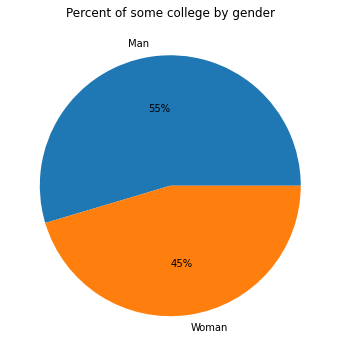

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

data['percent'] = (data['total_gender']/data['total'])*100

plt.pie(data['percent'], labels=data['gender'], autopct = '%0.0f%%')
plt.title("Percent of some college by gender")


Text(0.5, 1.0, 'Percent of graduated College by gender')

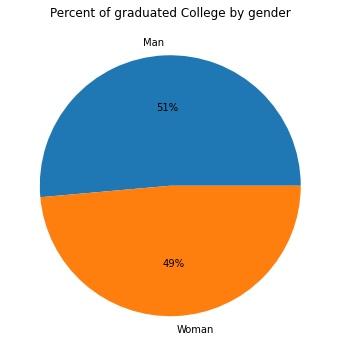

In [12]:
data = z_clg_table.groupby( [ 'gender' ] , as_index = False ).agg( 
                        total_gender = ( 'clg', np.sum ) , total = ('total_clg', np.mean))

fig, ax = plt.subplots(figsize=(10, 6))

data['percent'] = (data['total_gender']/data['total'])*100

plt.pie(data['percent'], labels=data['gender'], autopct = '%0.0f%%')
plt.title("Percent of graduated College by gender")

In particular, the table above shows that the difference in average *logwage* between men and women is equal to $0,0815$.

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [16]:
nocontrol_model = smf.ols( formula = 'lwage ~ sex', data = z_clg ) #WAS data=data
nocontrol_est = nocontrol_model.fit().summary2().tables[1]['Coef.']['sex']
HCV_coefs = nocontrol_model.fit().cov_HC0
nocontrol_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# print unconditional effect of gender and the corresponding standard error
print( f'The estimated gender coefficient is {nocontrol_est} and the corresponding robust standard error is {nocontrol_se}' )

nocontrol_model.fit().conf_int( alpha=0.05 ).loc['sex']

The estimated gender coefficient is -0.08150855508735895 and the corresponding robust standard error is 0.019579647767772348


0   -0.120022
1   -0.042995
Name: sex, dtype: float64

Note that the standard error is computed with the *R* package *sandwich* to be robust to heteroskedasticity. 


Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

Let us run the ols regression with controls.

## Ols regression with controls

In [17]:
# deleting shs, hsg, scl 
flex = 'lwage ~ sex + (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)'

# The smf api replicates R script when it transform data

control_model = smf.ols( formula = flex, data = z_clg ) #WAS data=data
control_est = control_model.fit().summary2().tables[1]['Coef.']['sex']

print(control_model.fit().summary2().tables[1])
print( f"Coefficient for OLS with controls {control_est}" )

HCV_coefs = control_model.fit().cov_HC0
control_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

control_model.fit().conf_int( alpha=0.05 ).loc['sex']

               Coef.  Std.Err.         t         P>|t|    [0.025    0.975]
Intercept   2.985101  0.336482  8.871492  1.250129e-18  2.325327  3.644876
occ2[T.10]  0.091982  0.243220  0.378184  7.053225e-01 -0.384925  0.568888
occ2[T.11] -0.499418  0.436858 -1.143202  2.530511e-01 -1.356010  0.357175
occ2[T.12]  0.190101  0.341142  0.557249  5.774012e-01 -0.478810  0.859012
occ2[T.13] -0.194529  0.271881 -0.715492  4.743637e-01 -0.727633  0.338575
...              ...       ...       ...           ...       ...       ...
exp3:we    -0.230864  0.184398 -1.251987  2.106777e-01 -0.592431  0.130704
exp4:clg   -0.013467  0.020134 -0.668849  5.036463e-01 -0.052945  0.026012
exp4:mw     0.014287  0.025814  0.553477  5.799802e-01 -0.036328  0.064902
exp4:so    -0.003759  0.022547 -0.166725  8.675981e-01 -0.047968  0.040450
exp4:we     0.028286  0.023812  1.187890  2.349761e-01 -0.018405  0.074978

[231 rows x 6 columns]
Coefficient for OLS with controls -0.0530623403577524


0   -0.091010
1   -0.015115
Name: sex, dtype: float64

The estimated regression coefficient $\beta_1\approx-0.0531$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $8$\% for women decreases to about $5$\% after controlling for worker characteristics.  


Next, we are using the Frisch-Waugh-Lovell theorem from the lecture partialling-out the linear effect of the controls via ols.

## Partialling-Out using ols

In [18]:
# models
# model for Y
flex_y = 'lwage ~  (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)' # deleting shs, hsg, scl 
# model for D
flex_d = 'sex ~ (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)' # deleting shs, hsg, scl 

# partialling-out the linear effect of W from Y
t_Y = smf.ols( formula = flex_y , data = z_clg ).fit().resid #WAS data=data

# partialling-out the linear effect of W from D
t_D = smf.ols( formula = flex_d , data = z_clg ).fit().resid #WAS data=data

data_res = pd.DataFrame( np.vstack(( t_Y.values , t_D.values )).T , columns = [ 't_Y', 't_D' ] )

# regression of Y on D after partialling-out the effect of W (regression between errors)
partial_fit =  smf.ols( formula = 't_Y ~ t_D' , data = data_res ).fit()
partial_est = partial_fit.summary2().tables[1]['Coef.']['t_D']

print("Coefficient for D via partialling-out", partial_est)

# standard error
HCV_coefs = partial_fit.cov_HC0
partial_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# confidence interval
partial_fit.conf_int( alpha=0.05 ).iloc[1, :]

Coefficient for D via partialling-out -0.05306234035775366


0   -0.089571
1   -0.016554
Name: t_D, dtype: float64

In [19]:
table3 = np.zeros( ( 3, 4 ) )

table3[0,0] = nocontrol_est
table3[0,1] = nocontrol_se 
table3[0,2] = nocontrol_model.fit().conf_int( alpha=0.05 ).loc['sex'][0]
table3[0,3] = nocontrol_model.fit().conf_int( alpha=0.05 ).loc['sex'][1] 

table3[1,0] = control_est
table3[1,1] = control_se  
table3[1,2] = control_model.fit().conf_int( alpha=0.05 ).loc['sex'][0]
table3[1,3] = control_model.fit().conf_int( alpha=0.05 ).loc['sex'][1] 

table3[2,0] =  partial_est
table3[2,1] = partial_se 
table3[2,2] = partial_fit.conf_int( alpha=0.05 ).loc['t_D'][0]
table3[2,3] = partial_fit.conf_int( alpha=0.05 ).loc['t_D'][1] 

table3_pandas = pd.DataFrame( table3, columns = [ "Estimate","Std. Error","Lower_bound" , "Upper_bound"])
table3_pandas.index = [ "OLS","OLS with controls", "Partialling out approach" ]

table3_pandas.reset_index(inplace = True)
table3_pandas.rename(columns = {"index" : "Model"}, inplace = True)

table3_pandas.round(8)

,Model,Estimate,Std. Error,Lower_bound,Upper_bound
0,OLS,-0.081509,0.019580,-0.120022,-0.042995
1,OLS with controls,-0.053062,0.193190,-0.091010,-0.015115
2,Partialling out approach,-0.053062,0.018353,-0.089571,-0.016554


Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

We know that the partialling-out approach works well when the dimension of $W$ is low
in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection
or penalization for regularization purposes. 

In [20]:
table3_pandas['errors'] = table3_pandas['Estimate'] - table3_pandas['Lower_bound']

C:\Users\Roberto\AppData\Local\Temp\ipykernel_18380\3324713581.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(table3_pandas.shape[0]),


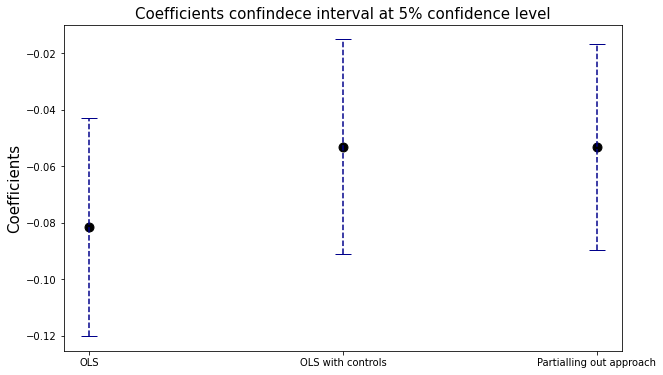

In [21]:
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(10, 6))
    
    
   # Coefficients
ax.scatter(x=pd.np.arange(table3_pandas.shape[0]), 
         marker='o', s=80, 
         y=table3_pandas['Estimate'], color='black')

# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
eb1 = plt.errorbar(x=table3_pandas["Model"], y=table3_pandas['Estimate'],
            yerr=table3_pandas['errors'], color = 'darkblue', ls='', capsize = 8)

eb1[-1][0].set_linestyle('--')
    
# Set title & labels
plt.title('Coefficients confindece interval at 5% confidence level',fontsize=15)
ax.set_ylabel('Coefficients',fontsize=15)
ax.set_xlabel('',fontsize=22)

    
plt.show()

# Graph: Experience profile and log-wage

### We will use seaborn module to plot our data

In [22]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Wage and experience relationship \n for people who went to college')

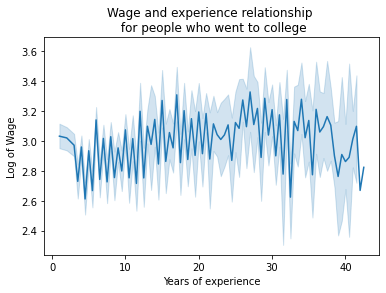

In [23]:
# Plot raw data of all sample (college + some college)
fig = sns.lineplot(data=z_clg, x="exp1", y="lwage")
plt.xlabel('Years of experience')
plt.ylabel('Log of Wage')
plt.title('Wage and experience relationship \n for people who went to college')

### Predictions - Quadratic 

C:\Users\Roberto\AppData\Local\Temp\ipykernel_18380\3060604518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_clg['lwage_quadratic'] = quadratic_pred.tolist() # a new column with quadratic prediction


Text(0.5, 1.0, 'Wage and experience relationship \n for people who went to college')

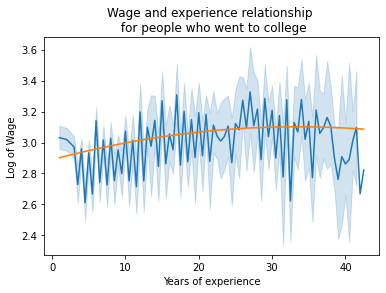

In [24]:
# Run a regression using experience^2 
quadratic   = "lwage ~  exp1+exp2"
quadratic_pred = smf.ols( formula = quadratic , data = z_clg ).fit().predict()
z_clg['lwage_quadratic'] = quadratic_pred.tolist() # a new column with quadratic prediction

# Plot wage fitted (using quadratic term) vs experience
sns.lineplot(data=z_clg, x="exp1", y="lwage")
sns.lineplot(data=z_clg, x="exp1", y="lwage_quadratic")
plt.xlabel('Years of experience')
plt.ylabel('Log of Wage')
plt.title('Wage and experience relationship \n for people who went to college')

### Predictions - Quartic 

C:\Users\Roberto\AppData\Local\Temp\ipykernel_18380\2573259064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_clg['lwage_quartic'] = quartic_pred.tolist() # a new column with quartic prediction


Text(0.5, 1.0, 'Wage and experience relationship \n for people who went to college')

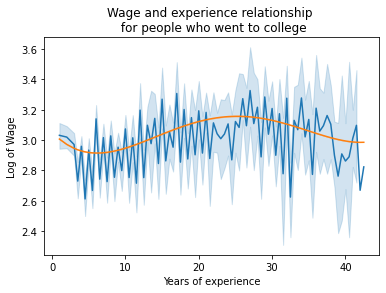

In [25]:
# Run a regression using experience^4 
quartic   = "lwage ~  exp1+exp2+exp3+exp4"
quartic_pred = smf.ols( formula = quartic , data = z_clg ).fit().predict()

z_clg['lwage_quartic'] = quartic_pred.tolist() # a new column with quartic prediction

# Plot wage fitted (using quartic term) vs experience
sns.lineplot(data=z_clg, x="exp1", y="lwage")
sns.lineplot(data=z_clg, x="exp1", y="lwage_quartic")
plt.xlabel('Years of experience')
plt.ylabel('Log of Wage')
plt.title('Wage and experience relationship \n for people who went to college')

### Predictions - using regplot

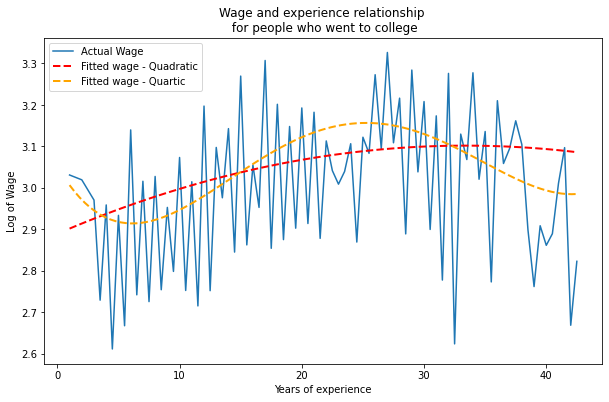

In [26]:
# Plot three lines using options from regplot
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=z_clg, x="exp1", y="lwage", ax=ax, ci=None,);

sns.regplot(x = z_clg.exp1, y=z_clg.lwage, color='red', scatter=False, order=2, x_estimator=np.mean, fit_reg=True, ci=None, line_kws={'lw':2})
sns.regplot(x = z_clg.exp1, y=z_clg.lwage, color='orange', scatter=False, order=4, x_estimator=np.mean, fit_reg=True, ci=None, line_kws={'lw':2})

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

plt.xlabel('Years of experience')
plt.ylabel('Log of Wage')
plt.title('Wage and experience relationship \n for people who went to college')
plt.legend(['Actual Wage','Fitted wage - Quadratic','Fitted wage - Quartic'])

### Predictions - using regplot and bins

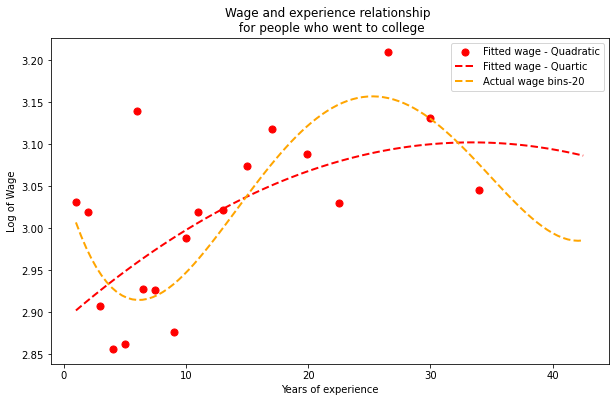

In [27]:
# We can also use the option bins from regplot to "split" data into bins
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.regplot(x = z_clg.exp1, y=z_clg.lwage, color='red', x_bins=20, order=2, x_estimator=np.mean, fit_reg=True, ci=None, line_kws={'lw':2})
sns.regplot(x = z_clg.exp1, y=z_clg.lwage, color='orange', scatter=False, order=4, x_estimator=np.mean, fit_reg=True, ci=None, line_kws={'lw':2})

ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")

plt.xlabel('Years of experience')
plt.ylabel('Log of Wage')
plt.title('Wage and experience relationship \n for people who went to college')
plt.legend(['Fitted wage - Quadratic','Fitted wage - Quartic','Actual wage bins-20'])

### Predictions - By groups 

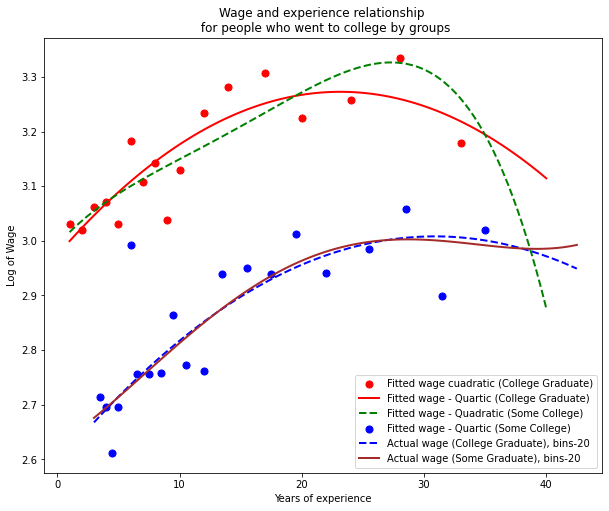

In [28]:
# Check analysis within groups (College Graduate & Some College) 
f, ax = plt.subplots(figsize=(10, 8))

sns.regplot(x = z_clg[z_clg['clg']==1].exp1, y=z_clg[z_clg['clg']==1].lwage, 
            color='red', x_bins=20, order=2, x_estimator=np.mean, fit_reg=True, 
            ci=None, line_kws={'lw':2})

sns.regplot(x = z_clg[z_clg['clg']==1].exp1, y=z_clg[z_clg['clg']==1].lwage, 
            color='green', scatter=False, order=4, x_estimator=np.mean, fit_reg=True, 
            ci=None, line_kws={'lw':2})

sns.regplot(x = z_clg[z_clg['clg']==0].exp1, y=z_clg[z_clg['clg']==0].lwage, 
            color='blue', x_bins=20, order=2, x_estimator=np.mean, fit_reg=True, 
            ci=None, line_kws={'lw':2})

sns.regplot(x = z_clg[z_clg['clg']==0].exp1, y=z_clg[z_clg['clg']==0].lwage, 
            color='brown', scatter=False, order=4, x_estimator=np.mean, fit_reg=True, 
            ci=None, line_kws={'lw':2})

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

plt.xlabel('Years of experience')
plt.ylabel('Log of Wage')
plt.title('Wage and experience relationship \n for people who went to college by groups')

plt.legend(['Fitted wage cuadratic (College Graduate)','Fitted wage - Quartic (College Graduate)',
            'Fitted wage - Quadratic (Some College)' , 'Fitted wage - Quartic (Some College)', 
            'Actual wage (College Graduate), bins-20', 'Actual wage (Some Graduate), bins-20'])